In [1]:
# Model calibration: identification of parameters
print('Model calibration on Lorenz model')

# load libraries
import numpy
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# true model parameters
st = 10.0
rt = 28.0
bt = 8.0/3.0

# time window and time step
T = 4.0
dt = 0.001
nt = int(T/dt)+1

# time frequency of observations
freqobs = 100
dtobs = freqobs*dt
ntobs = int(T/dtobs)+1

Model calibration on Lorenz model


In [2]:
# resolution of Lorenz model
def lorenz(u0,s,r,b):
    u = numpy.zeros((nt,3))
    u[0,:] = u0
    for i in range(1,nt):
        u[i,0] = u[i-1,0]+dt*s*(u[i-1,1]-u[i-1,0])
        u[i,1] = u[i-1,1]+dt*(r*u[i-1,0]-u[i-1,1]-u[i-1,0]*u[i-1,2])
        u[i,2] = u[i-1,2]+dt*(u[i-1,0]*u[i-1,1]-b*u[i-1,2])
    return u

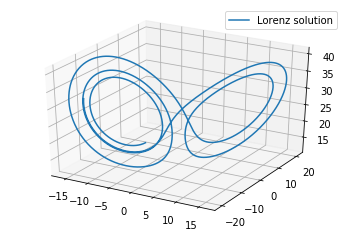

In [3]:
# true state and true solution
u0true = numpy.array([-4.62,-6.61,17.94])
utrue = lorenz(u0true,st,rt,bt)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(utrue[:,0],utrue[:,1],utrue[:,2])
ax.legend(['Lorenz solution'])

In [4]:
# Observation generation (with noise)
uobs = lorenz(u0true,st,rt,bt)
noiselevel = 0.0
noise = numpy.random.randn(nt,3)
uobs = uobs + noiselevel*noise

# Covariance matrix
R = numpy.identity(3)
Rinv = numpy.linalg.inv(R)

In [5]:
# Background state and trajectory
#ub0 = numpy.array([-4.0,-6.0,18.0])
ub0 = u0true
sb = 10.4
rb = 28.4
bb = 3.0
# full control vector
xb0 = numpy.zeros(6)
xb0[0:3] = ub0
xb0[3] = sb
xb0[4] = rb
xb0[5] = bb
ub = lorenz(ub0,sb,rb,bb)
B = numpy.identity(3)
Binv = numpy.linalg.inv(B)
Bparam = numpy.identity(3)
Bparaminv = numpy.linalg.inv(B)

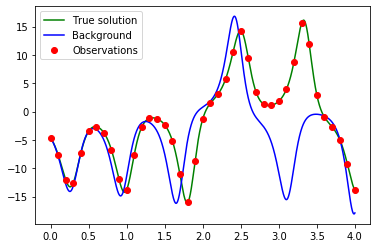

In [6]:
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
ax2.plot(numpy.arange(0,T+0.9*dt,dt),utrue[:,0],'g',numpy.arange(0,T+0.9*dt,dt),ub[:,0],'b',numpy.arange(0,T+0.9*dt,dt*freqobs),uobs[0:nt:freqobs,0],'ro')
ax2.legend(['True solution','Background','Observations'])

In [7]:
# 4D-VAR method for parameter estimation
print('4D-VAR method')
# weights Jo/Jb
wo = freqobs/nt
wb = 0
wbp = 0

4D-VAR method


In [8]:
# adjoint resolution
def lorenzadj(u,s,r,b):
    uadj = numpy.zeros((nt,3))
    # final condition
    uadj[nt-1,:] = 0.0
    # in case of final observation
    if numpy.mod(nt-1,freqobs) == 0:
        uadj[nt-1,:] = uadj[nt-1,:]+wo*Rinv.dot(u[nt-1,:]-uobs[nt-1,:])
    for i in range(nt-1,0,-1):
        uadj[i-1,0] = uadj[i,0]-dt*(s*uadj[i,0]-(r-u[i,2])*uadj[i,1]-u[i,1]*uadj[i,2])
        uadj[i-1,1] = uadj[i,1]-dt*(-s*uadj[i,0]+uadj[i,1]-u[i,0]*uadj[i,2])
        uadj[i-1,2] = uadj[i,2]-dt*(b*uadj[i,2]+u[i,0]*uadj[i,1])
        # in case of observation
        if numpy.mod(i-1,freqobs) == 0:
            uadj[i-1,:] = uadj[i-1,:]+wo*Rinv.dot(u[i-1,:]-uobs[i-1,:])
    return uadj

In [9]:
# cost function and gradient
def cost(x):
    u0 = x[0:3]
    s = x[3]
    r = x[4]
    b = x[5]
    # Jb
    J = 0.5*wb*numpy.dot(u0-ub0,Binv.dot(u0-ub0))
    # Jb parameters
    J = J + 0.5*wbp*numpy.dot(x[3:6],Bparaminv.dot(x[3:6]))
    # direct solution
    u = lorenz(u0,s,r,b)
    # Jo
    for i in range(0,nt,freqobs):
        J = J+0.5*wo*numpy.dot(u[i,:]-uobs[i,:],Rinv.dot(u[i,:]-uobs[i,:]))
    return J

def gradient(x):
    u0 = x[0:3]
    s = x[3]
    r = x[4]
    b = x[5]
    # direct solution
    u = lorenz(u0,s,r,b)
    # adjoint solution
    uadj = lorenzadj(u,s,r,b)
    # gradient
    gradJ = numpy.zeros(6)
    gradJ[0:3] = uadj[0,:]+wb*Binv.dot(u0-ub0)
    # integral of (y-x)*xad
    gradJ[3] = dt*numpy.sum(numpy.dot(u[:,1]-u[:,0],uadj[:,0]))
    # integral of x*yad
    gradJ[4] = dt*numpy.sum(numpy.dot(u[:,0],uadj[:,1]))
    # integral of -z*zad
    gradJ[5] = -dt*numpy.sum(numpy.dot(u[:,2],uadj[:,2]))
    gradJ[3:6] = gradJ[3:6]+wbp*Bparaminv.dot(x[3:6])
    return gradJ

In [10]:
res = minimize(cost,xb0,method='BFGS',jac=gradient,options={'maxiter': 400})
res

      fun: 2.513030050383831e-14
 hess_inv: array([[ 23.32524744, -17.0776972 ,   7.50141081,   1.55973672,
         -0.64715041,  -0.02350287],
       [-17.0776972 ,  14.30587293,  -5.46428602,   0.23472208,
          0.10844554,   0.03858893],
       [  7.50141081,  -5.46428602,   3.91199578,   0.70796418,
          0.49866832,  -0.17525815],
       [  1.55973672,   0.23472208,   0.70796418,   3.10229   ,
         -0.80006867,  -0.13309032],
       [ -0.64715041,   0.10844554,   0.49866832,  -0.80006867,
          0.60009649,  -0.04496312],
       [ -0.02350287,   0.03858893,  -0.17525815,  -0.13309032,
         -0.04496312,   0.02803547]])
      jac: array([ 1.61031041e-06,  6.68110415e-07, -3.30809841e-06,  6.00442361e-07,
        4.53836197e-06, -9.57567337e-06])
  message: 'Optimization terminated successfully.'
     nfev: 81
      nit: 70
     njev: 81
   status: 0
  success: True
        x: array([-4.62000049, -6.60999956, 17.93999984,  9.99999981, 28.00000006,
        2.666666

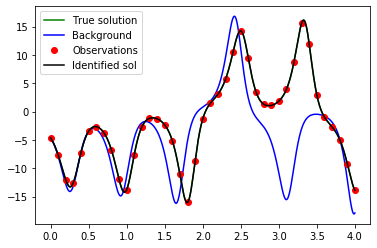

In [11]:
# forecast with identified parameters
sol = res.x
uid0 = sol[0:3]
sid = sol[3]
rid = sol[4]
bid = sol[5]
uid = lorenz(uid0,sid,rid,bid)
fig3 = plt.figure()
ax3 = fig3.add_subplot(111)
ax3.plot(numpy.arange(0,T+0.9*dt,dt),utrue[:,0],'g',numpy.arange(0,T+0.9*dt,dt),ub[:,0],'b',numpy.arange(0,T+0.9*dt,dt*freqobs),uobs[0:nt:freqobs,0],'ro',numpy.arange(0,T+0.9*dt,dt),uid[:,0],'k')
ax3.legend(['True solution','Background','Observations','Identified sol'])